## Beyond sporadic outbreaks: Classifying and explaining dengue endemicity over scenarios of global change.

*CPSC 581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*

*Student: Hailey Robertson*

## Set up

#### Import packages

In [1]:
# pip install -r requirements.txt

In [2]:
import numpy as np
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpreprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, Ridge
from sklearn.cluster import KMeans, MeanShift
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd


# Geospatial
import geopandas as gpd
from shapely.geometry import MultiPolygon 
import country_converter as coco

# Other
import warnings
import json

warnings.filterwarnings(action='ignore')
np.random.seed(42)

/Users/haileyrobertson/Documents/GitHub/robertson-cpsc581/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Nice defaults for plotting

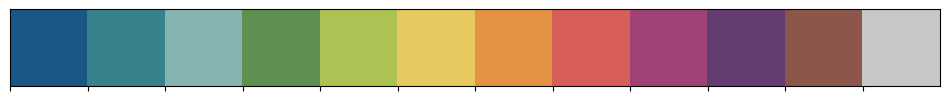

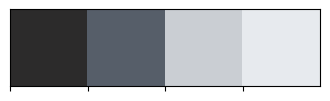

In [3]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# # Add every font at the specified location
# font_dir = ['/Users/haileyrobertson/Library/Fonts']
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 10

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Create data

#### Load Open Dengue and align country names

In [4]:
# --- Load dengue data ---
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
open_dengue = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

open_dengue["adm_0_iso3"] = coco.convert(
    names=open_dengue["adm_0_name"],
    to='ISO3',
    not_found="missing"
)

date_cols = ['calendar_start_date', 'calendar_end_date']
open_dengue[date_cols] = open_dengue[date_cols].apply(pd.to_datetime)
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year
open_dengue['month'] = open_dengue['calendar_start_date'].dt.month

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# --- Load world geometry ---
world = gpd.read_file("../data/ne_110m_admin_0_countries")

world = world.rename(columns={
    "ADM0_A3": "adm_0_iso3",
    "ADMIN": "adm_0_name",
    "REGION_UN": "region_un",
    "geometry": "adm_0_geometry"
})[["adm_0_iso3", "adm_0_name", "region_un", "adm_0_geometry"]]

world = world.sort_values(by="adm_0_name")

# --- Fix known issues ---
# Split out French Guiana from France
france_idx = world['adm_0_name'] == 'France'
france_geom = world.loc[france_idx, 'adm_0_geometry'].values[0]

if isinstance(france_geom, MultiPolygon):
    polygons = list(france_geom.geoms)
    french_guiana_polygon = next((poly for poly in polygons if poly.bounds[0] < -50 and poly.bounds[2] > -54), None)

    if french_guiana_polygon:
        # Remove French Guiana from France
        remaining_polygons = [poly for poly in polygons if poly != french_guiana_polygon]
        world.loc[france_idx, 'adm_0_geometry'] = MultiPolygon(remaining_polygons)

        # Add French Guiana as separate entry
        french_guiana_row = {
            'adm_0_iso3': 'GUF',
            'adm_0_name': 'French Guiana',
            'region_un': 'Americas',
            'adm_0_geometry': french_guiana_polygon
        }
        world = pd.concat([world, gpd.GeoDataFrame([french_guiana_row], geometry='adm_0_geometry')], ignore_index=True)

# Patch ISO3 codes for special cases
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'
world.loc[world['adm_0_name'] == 'South Sudan', 'adm_0_iso3'] = 'SSD'

# --- Merge dengue data with geometry ---
dengue = pd.merge(open_dengue, world, on='adm_0_iso3', how='outer', suffixes=('', '_world'))

# Fill UN regions with mapping
with open('../data/un_regions.json') as f:
    countries = json.load(f)
dengue['region_un'] = dengue['adm_0_iso3'].map(countries).fillna("Other")

# Aesthetics
dengue = dengue.drop(columns=['adm_0_name_world'])
front_cols = ['adm_0_name', 'adm_0_iso3']
geometry_col = ['adm_0_geometry']
other_cols = [col for col in dengue.columns if col not in front_cols + geometry_col]
dengue = dengue[front_cols + other_cols + geometry_col]

# Fill the years so that ISO3s stay as a time series
years = pd.Series(range(int(1950), int(dengue['year'].max()) + 1))
unique_iso3 = dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

dengue_ts = all_combinations.merge(dengue, on=['adm_0_iso3', 'year'], how='outer')

# List of columns to fill
columns_to_fill = ['adm_0_name', 'region_un', 'adm_0_geometry']

# Fill NaN values for multiple columns
dengue_ts[columns_to_fill] = (
    dengue_ts
    .groupby('adm_0_iso3')[columns_to_fill]
    .transform(lambda x: x.ffill().bfill())
)

dengue_ts = dengue_ts.dropna(subset=['year'])

#### Load population first

In [5]:
# --- Clean population data ---
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': int,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]
pop.rename(columns={"ISO3_code": "adm_0_iso3", "Time": "year", "TPopulation1July": "TPopulation1July_per_1000"}, inplace=True)
pop['year'] = pd.to_numeric(pop['year'], errors='coerce').astype('Int64')
dengue_ts = dengue_ts.merge(pop, how='outer', on=['adm_0_iso3', 'year'])

#### Calculate incidence rates

In [6]:
grouped_df = dengue_ts.groupby(['adm_0_iso3', 
                                'year',
                                'region_un',
                                'TPopulation1July_per_1000'
                                ]).agg({
    'dengue_total': 'sum'
}).reset_index()

grouped_df['TPopulation1July'] = grouped_df['TPopulation1July_per_1000'] * 1000
grouped_df['incidence'] = grouped_df['dengue_total'] / grouped_df['TPopulation1July']
grouped_df['incidence_per_100k'] = grouped_df['incidence'] * 100000
grouped_df['log_incidence_per_100k'] = np.log1p(grouped_df['incidence_per_100k'])  # log(x + 1) to handle zero values

#### Load other predictors

In [7]:
# --- Clean population density ---
pop_dns = pd.read_csv("../data/pop_density_wb.csv")
year_cols = [col for col in pop_dns.columns if col.isdigit()]
pop_dns = pop_dns.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="pop_density_per_km2"
)
pop_dns.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)

# --- Clean climate data ---
clim = ['era5_tnn_annual_min_temp.csv', 'era5_tas_annual_mean_temp.csv', 'era5_pr_annual_mean_precipitation.csv', 'era5_hur_annual_mean_relative_humidity.csv']

climate_df = {}

for file in clim:
    data = pd.read_csv(f"../data/{file}")
    
    year_cols = [col for col in data.columns if col.startswith('19') or col.startswith('20')]

    melted = data.melt(
        id_vars=["code"],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    melted["year"] = melted["year"].str.extract(r"(\d{4})")
    melted.rename(columns={"code": "adm_0_iso3"}, inplace=True)
    indicator = file.replace('.csv', '')  
    melted.rename(columns={"value": indicator}, inplace=True)
    climate_df[indicator] = melted

# --- Clean urbanization data ---
urban = pd.read_csv("../data/urban_growth_wb.csv")

year_cols = [col for col in urban.columns if col.startswith('19') or col.startswith('20')]

urban = urban.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="urban_growth"
)
urban.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
urban['year'] = urban['year'].str.extract(r"(\d{4})")

# --- Clean urban pop data ---
u_pop = pd.read_csv("../data/urban_pop_wb.csv")

year_cols = [col for col in u_pop.columns if col.startswith('19') or col.startswith('20')]

u_pop = u_pop.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="urban_pop"
)
u_pop.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
u_pop['year'] = urban['year'].str.extract(r"(\d{4})")

# --- Clean GDP data ---
gdp = pd.read_csv("../data/gdp_ppp_wb.csv")

year_cols = [col for col in gdp.columns if col.startswith('19') or col.startswith('20')]

gdp = gdp.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="gdp_ppp"
)
gdp.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
gdp['year'] = gdp['year'].str.extract(r"(\d{4})")

# --- Clean arrivals data ---
arr = pd.read_csv("../data/tourism_arrivals_wb.csv")

year_cols = [col for col in arr.columns if col.startswith('19') or col.startswith('20')]

arr = arr.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_arrivals"
)
arr.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
arr['year'] = arr['year'].str.extract(r"(\d{4})")

# --- Clean departures data ---
dep = pd.read_csv("../data/tourism_departures_wb.csv")

year_cols = [col for col in dep.columns if col.startswith('19') or col.startswith('20')]

dep = dep.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_departures"
)
dep.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
dep['year'] = dep['year'].str.extract(r"(\d{4})")

In [8]:
predictor_dfs = [pop_dns, 
                 climate_df['era5_hur_annual_mean_relative_humidity'],
                 climate_df['era5_pr_annual_mean_precipitation'],
                 climate_df['era5_tas_annual_mean_temp'],
                 climate_df['era5_tnn_annual_min_temp'],
                 u_pop,
                 gdp,
                 arr,
                 dep]

merged_df = grouped_df.copy()

for i, predictor in enumerate(predictor_dfs):
    predictor['year'] = pd.to_numeric(predictor['year'], errors='coerce').astype('Int64')
    predictor = predictor.dropna(subset=['adm_0_iso3', 'year'])
    merged_df = merged_df.merge(predictor, how='outer', on=['adm_0_iso3', 'year'])

df = merged_df.replace('..', np.nan)
df = df[(df['year'] >= 1950) & (df['year'] <= 2022)]
df = df.dropna(subset=['region_un', 'adm_0_iso3', 'year'])
df.drop_duplicates(subset=['adm_0_iso3', 'year'], inplace=True)
print(df.columns)
print(df.shape)

# df.to_csv('../output/data/cleaned_master_df.csv', index=False)


Index(['adm_0_iso3', 'year', 'region_un', 'TPopulation1July_per_1000',
       'dengue_total', 'TPopulation1July', 'incidence', 'incidence_per_100k',
       'log_incidence_per_100k', 'pop_density_per_km2',
       'era5_hur_annual_mean_relative_humidity',
       'era5_pr_annual_mean_precipitation', 'era5_tas_annual_mean_temp',
       'era5_tnn_annual_min_temp', 'urban_pop', 'gdp_ppp', 'tourism_arrivals',
       'tourism_departures'],
      dtype='object')
(15549, 18)


##### View data coverage

In [9]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
heatmap_data = df.pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)
print(len(heatmap_data))
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 1000))))

# Plot
fig, ax = plt.subplots(figsize=(10, 16))  

custom_colors = ["white", colors[1]]

# Plot the heatmap
im = sns.heatmap(data=heatmap_data, 
                 cmap=custom_cmap, 
                 annot=False, 
                 fmt='g', 
                 linewidths=0.1, 
                 ax=ax, 
                 vmin=0, 
                 vmax=1000, 
                 cbar=True, 
                 cbar_kws={'orientation': 'horizontal', 'pad': 0.04, 'label':'Incidence rate per 100,000'})

# Set tick labels and axis labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.set_title("Incidence rate per 100,000 over time",loc='left', fontsize=14)

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=6, width=10)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index, fontsize=6)

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_1950-2023_full_covg.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

213


## Aim 1: Classify countries by endemicity status

#### Cluster with k-means

##### Check multicollinearity with VIF and cluster with all features

In [32]:
# --- Load cleaned data ---
df = pd.read_csv('../output/data/cleaned_master_df.csv')

# --- VIF filtering ---
features = {
    'era5_tas_annual_mean_temp': 'Mean temperature (°C)',
    'era5_pr_annual_mean_precipitation': 'Mean precipitation (mm)',
    'era5_hur_annual_mean_relative_humidity': 'Mean relative humidity (%)',
    'urban_pop': 'Urban population (%)',
    'gdp_ppp': 'GDP per capita (PPP)',
    'tourism_arrivals': 'International tourism arrivals',
    'tourism_departures': 'International tourism departures',
    'pop_density_per_km2': 'Population density (people/km²)',
    'TPopulation1July': 'Population size',
    'log_incidence_per_100k': 'Log incidence per 100,000'
}

df_features = df[list(features.keys())].dropna().rename(columns=features)
corr = df_features.corr()

# --- VIF Filtering Function ---
def calculate_vif(df, thresh=5):
    """
    Removes features with VIF above the threshold.
    """
    variables = df.copy()
    dropped = True
    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["variable"] = variables.columns
        vif["VIF"] = [variance_inflation_factor(add_constant(variables).values, i + 1)
                      for i in range(variables.shape[1])]
        
        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            drop_var = vif.sort_values("VIF", ascending=False)["variable"].iloc[0]
            print(f"Dropping '{drop_var}' with VIF = {max_vif:.2f}")
            variables = variables.drop(columns=[drop_var])
            dropped = True
        else:
            print(f"All variables have VIF < {thresh}")
    return variables

# --- Apply VIF filtering and scale ---
df_features_cleaned = calculate_vif(df_features)
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_features_cleaned)

# --- K-Means clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_cleaned = df_features_cleaned.copy()  
df_cleaned['kmeans_cluster'] = clusters

sil_score = skmetrics.silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# --- PCA for visualization ---
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_cleaned['kmeans_cluster'],
    palette=colors[4:7],
    ax=ax,
    s=50,
    legend='full'
)

ax.set_title(f'K-Means clusters in PCA space (All features)')    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

legend = ax.legend(title='Cluster', loc='best', frameon=True)

fig.tight_layout()
filename = f"../output/figures/kmeans_pca_clusters_all_features.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

all_features_clusters = df.loc[df_cleaned.index, ['adm_0_iso3', 'year']].copy()

all_features_clusters['kmeans_cluster'] = df_cleaned['kmeans_cluster']

all_features_clusters = pd.merge(df, all_features_clusters, on=['adm_0_iso3', 'year'], how='left')

all_features_clusters.to_csv(f'../output/data/all_features_kmeans_cluster_labels_by_country_year.csv', index=False)


All variables have VIF < 5
Silhouette Score: 0.304


##### Cluster with only incidence-correlated features

In [35]:
# Select only the two features that were highly correlated with incidence (primary measure of endemicity)
corr_features = {
    'era5_tas_annual_mean_temp': 'Mean temperature (°C)',
    'era5_pr_annual_mean_precipitation': 'Mean precipitation (mm)'
}

df_corr_features = df[list(corr_features.keys())].dropna().rename(columns=corr_features)

# --- K-Means clustering ---
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_corr_features)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_corr_clusters = df_corr_features.copy()
df_corr_clusters['kmeans_cluster'] = clusters

sil_score = skmetrics.silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# --- PCA for visualization ---
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_corr_clusters['kmeans_cluster'],
    palette=colors[4:7],
    ax=ax,
    s=50,
    legend='full'
)

ax.set_title(f'K-Means clusters in PCA space (Incidence-correlated features)')    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

legend = ax.legend(title='Cluster', loc='best', frameon=True)

fig.tight_layout()
filename = f"../output/figures/kmeans_pca_clusters_incidence_correlated_features.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

df_with_clusters = df.loc[df_corr_clusters.index, ['adm_0_iso3', 'year']].copy()

df_with_clusters['kmeans_cluster'] = df_corr_clusters['kmeans_cluster']

df_with_clusters = pd.merge(df, df_with_clusters, on=['adm_0_iso3', 'year'], how='left')

df_with_clusters.to_csv(f'../output/data/incidence_correlated_kmeans_cluster_labels_by_country_year.csv', index=False)

cluster_palette = {0: colors[6], 1: colors[5], 2: colors[4]}  

legend_labels = ["Endemic", "Hypo-endemic", "Non-endemic"]

plt.figure(figsize=(20, 30))

scatter = sns.scatterplot(
    data=df_with_clusters,
    x='year',
    y='adm_0_iso3',
    hue='kmeans_cluster',
    size='log_incidence_per_100k',
    sizes=(1, 200),
    palette=cluster_palette,
    alpha=0.7,
    edgecolor=chart[1],
    linewidth=0.5
)

plt.title("Cluster membership over time by country (incidence correlated features)", loc ='left')
plt.xlabel("Year")
plt.ylabel("Country", labelpad=10)

handles, labels = scatter.get_legend_handles_labels()

hue_title_idx = labels.index("kmeans_cluster")
size_title_idx = labels.index("log_incidence_per_100k")

hue_handles = handles[hue_title_idx+1:size_title_idx]
size_handles = handles[size_title_idx+1:]

new_labels = legend_labels

legend1 = plt.legend(
    handles=hue_handles,
    labels=new_labels,
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    handletextpad=0.4,    
    borderaxespad=0.1,    
    alignment='left'
)     

legend2 = plt.legend(
    handles=size_handles,
    labels=labels[size_title_idx+1:],
    title="Log incidence per 100k",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.92),
    handletextpad=0.4,
    borderaxespad=0.1,
    alignment='left',
)

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("../output/figures/incidence_correlated_timeline_cluster_plot.png", dpi=1000, bbox_inches='tight')
plt.close()

Silhouette Score: 0.503


##### Cluster with only incidence

In [12]:
df_inc = df[["log_incidence_per_100k"]].dropna()

# --- K-Means clustering ---
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_inc)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_inc_cleaned = df_inc.copy()  
df_inc_cleaned['kmeans_cluster'] = clusters

sil_score = skmetrics.silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# --- Timeline plot ---
df_with_inc_clusters = df.loc[df_inc_cleaned.index, ['adm_0_iso3', 'year']].copy()

df_with_inc_clusters['kmeans_cluster'] = df_inc_cleaned['kmeans_cluster']


df_with_inc_clusters = pd.merge(df, df_with_inc_clusters, on=['adm_0_iso3', 'year'], how='left')

df_with_inc_clusters.to_csv(f'../output/data/incidence_kmeans_cluster_labels_by_country_year.csv', index=False)

plt.figure(figsize=(20, 30))

cluster_palette = {0: colors[6], 1: colors[4], 2: colors[5]}  
legend_labels = ["Endemic", "Non-endemic", "Hypo-endemic"]

scatter = sns.scatterplot(
    data=df_with_inc_clusters,
    x='year',
    y='adm_0_iso3',
    hue='kmeans_cluster',
    size='log_incidence_per_100k',
    sizes=(1, 200),
    palette=cluster_palette,
    alpha=0.7,
    edgecolor=chart[1],
    linewidth=0.5
)

plt.title("Cluster membership over time by country (incidence)", loc ='left')
plt.xlabel("Year")
plt.ylabel("Country", labelpad=10)

handles, labels = scatter.get_legend_handles_labels()

hue_title_idx = labels.index("kmeans_cluster")
size_title_idx = labels.index("log_incidence_per_100k")

hue_handles = handles[hue_title_idx+1:size_title_idx]
size_handles = handles[size_title_idx+1:]

new_labels = legend_labels

legend1 = plt.legend(
    handles=hue_handles,
    labels=new_labels,
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    handletextpad=0.4,    
    borderaxespad=0.1,    
    alignment='left'
)     

legend2 = plt.legend(
    handles=size_handles,
    labels=labels[size_title_idx+1:],
    title="Log incidence per 100k",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.92),
    handletextpad=0.4,
    borderaxespad=0.1,
    alignment='left',
)

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("../output/figures/incidence_timeline_kmeans_cluster_plot.png", dpi=300, bbox_inches='tight')
plt.close()

# --- Scatter for visualization ---
plt.figure(figsize=(10, 14))

sns.scatterplot(
    data=df_with_inc_clusters.dropna(subset=['log_incidence_per_100k', 'kmeans_cluster']),
    x='log_incidence_per_100k',
    y='adm_0_iso3',
    hue='kmeans_cluster',
    palette=cluster_palette,
    alpha=0.7,
    s=30,
    edgecolor=chart[1],
    linewidth=0.5
)

plt.title("Incidence cluster distribution", loc='left')
plt.xlabel("log(incidence per 100k)")
plt.ylabel("Country")

plt.legend(
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.92)
)

plt.tight_layout()
plt.savefig("../output/figures/incidence_kmeans_cluster_scatter_by_country.png", dpi=300, bbox_inches='tight')
plt.close()

# --- 3D scatter for viz ---
plot_df = df_with_inc_clusters.dropna(subset=['log_incidence_per_100k', 'kmeans_cluster']).copy()

country_order = {country: i for i, country in enumerate(sorted(plot_df['adm_0_iso3'].unique()))}
plot_df['country_num'] = plot_df['adm_0_iso3'].map(country_order)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

custom_cluster_colors = [colors[3], colors[5], colors[6]]  # Instead of 4, 5, 6

cluster_labels = sorted(plot_df['kmeans_cluster'].unique())
cluster_palette = {
    label: custom_cluster_colors[i] for i, label in enumerate(cluster_labels)
}

plot_df['cluster_color'] = plot_df['kmeans_cluster'].map(cluster_palette)

# 3D Scatter using custom color list
sc = ax.scatter(
    plot_df['year'],
    plot_df['country_num'],
    plot_df['log_incidence_per_100k'],
    color=plot_df['cluster_color'],  # Use actual RGB colors
    s=10,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.2
)


# Axis labels
ax.set_xlabel('Year', labelpad=10)
ax.set_ylabel('Country')
ax.set_zlabel('log(incidence per 100k)', labelpad=10)

# Set y-ticks to country codes
yticks = list(country_order.values())
yticklabels = list(country_order.keys())

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=2) 

for label in ax.get_yticklabels():
    label.set_rotation(0)  

ax.set_ylim(-1, len(country_order))

# Define your legend labels
legend_labels = ["Endemic", "Non-endemic", "Hypo-endemic"]

legend_handles = [
    Patch(facecolor=custom_cluster_colors[i], label=legend_labels[i])
    for i in range(len(legend_labels))
]

# Add legend to the plot
ax.legend(
    handles=legend_handles,
    title='Cluster',
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.title("3D Scatter of Incidence Clusters by Country and Year", loc='left')
plt.tight_layout()
plt.savefig("../output/figures/incidence_clusters_3d_scatter.png", dpi=300, bbox_inches='tight')
plt.close()

Silhouette Score: 0.917


#### Cluster with mean shift

##### All predictors

In [13]:
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_features_cleaned)

# --- K-Means clustering ---
meanshift = MeanShift()
clusters = meanshift.fit_predict(X_scaled)
df_features_cleaned['meanshift_cluster'] = clusters

sil_score = skmetrics.silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# --- PCA for visualization ---
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_features_cleaned['meanshift_cluster'],
    palette=colors[::2],
    ax=ax,
    s=50,
    legend='full'
)

ax.set_title(f'Meanshift clusters in PCA space (All features)')    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

legend = ax.legend(title='Cluster', loc='best', frameon=True)

fig.tight_layout()
filename = f"../output/figures/meanshift_pca_clusters_all_features.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

Silhouette Score: 0.408


##### Incidence-correlated 

In [14]:
# --- K-Means clustering ---
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_corr_features)

meanshift = MeanShift()
clusters = meanshift.fit_predict(X_scaled)
df_corr_features['meanshift_cluster'] = clusters

if len(np.unique(clusters)) > 1:
    sil_score = skmetrics.silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("Silhouette Score: Cannot compute (only 1 cluster found)")


# --- PCA for visualization ---
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_corr_features['meanshift_cluster'],
    palette=colors[::2],
    ax=ax,
    s=50,
    legend='full'
)

ax.set_title(f'Mean shift clusters in PCA space (Incidence-correlated features)')    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

legend = ax.legend(title='Cluster ', loc='best', frameon=True)

fig.tight_layout()
filename = f"../output/figures/meanshift_pca_clusters_incidence_correlated_features.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

df_with_meanshift_clusters = df.loc[df_corr_features.index, ['adm_0_iso3', 'year']].copy()

df_with_meanshift_clusters['meanshift_cluster'] = df_corr_features['meanshift_cluster']

df_with_meanshift_clusters = pd.merge(df, df_with_meanshift_clusters, on=['adm_0_iso3', 'year'], how='left')

df_with_meanshift_clusters.to_csv(f'../output/data/incidence_correlated_meanshift_cluster_labels_by_country_year.csv', index=False)

every_other_color = colors[::2]
cluster_palette = {
    cluster: every_other_color[i]
    for i, cluster in enumerate(np.unique(clusters))
}


legend_labels = [f"Cluster {i}" for i in np.unique(clusters)]

plt.figure(figsize=(20, 30))

scatter = sns.scatterplot(
    data=df_with_meanshift_clusters,
    x='year',
    y='adm_0_iso3',
    hue='meanshift_cluster',
    size='log_incidence_per_100k',
    sizes=(1, 200),
    palette=cluster_palette,
    alpha=0.7,
    edgecolor=chart[1],
    linewidth=0.5
)

plt.title("Cluster membership over time by country (incidence correlated features)", loc ='left')
plt.xlabel("Year")
plt.ylabel("Country", labelpad=10)

handles, labels = scatter.get_legend_handles_labels()

hue_title_idx = labels.index("meanshift_cluster")
size_title_idx = labels.index("log_incidence_per_100k")

hue_handles = handles[hue_title_idx+1:size_title_idx]
size_handles = handles[size_title_idx+1:]

new_labels = legend_labels

legend1 = plt.legend(
    handles=hue_handles,
    labels=new_labels,
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    handletextpad=0.4,    
    borderaxespad=0.1,    
    alignment='left'
)     

legend2 = plt.legend(
    handles=size_handles,
    labels=labels[size_title_idx+1:],
    title="Log incidence per 100k",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.92),
    handletextpad=0.4,
    borderaxespad=0.1,
    alignment='left',
)

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("../output/figures/incidence_correlated_timeline_meanshift_cluster_plot.png", dpi=1000, bbox_inches='tight')
plt.close()

Silhouette Score: 0.439


##### Incidence only

In [15]:
# --- K-Means clustering ---
scaler = skpreprocessing.StandardScaler()
X_scaled = scaler.fit_transform(df_inc)
meanshift = MeanShift()
clusters = meanshift.fit_predict(X_scaled)

df_inc_cleaned = df_inc.copy()  
df_inc_cleaned['meanshift_cluster'] = clusters

sil_score = skmetrics.silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# # --- PCA for visualization ---
# pca_2d = PCA(n_components=2)
# X_2d = pca_2d.fit_transform(X_scaled)

# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(
#     x=X_2d[:, 0],
#     y=X_2d[:, 1],
#     hue=df_corr_cleaned['meanshift_cluster'],
#     palette=colors[4:7],
#     ax=ax,
#     s=50,
#     legend='full'
# )

# ax.set_title(f'K-Means clusters in PCA space (Incidence and temperature)')    
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')

# legend = ax.legend(title='Cluster', loc='best', frameon=True)

# fig.tight_layout()
# filename = f"../output/figures/meanshift_pca_clusters_temp_precipitation.png"
# plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
# plt.close()

# --- Timeline plot ---
df_with_inc_clusters = df.loc[df_inc_cleaned.index, ['adm_0_iso3', 'year']].copy()

df_with_inc_clusters['meanshift_cluster'] = df_inc_cleaned['meanshift_cluster']


df_with_inc_clusters = pd.merge(df, df_with_inc_clusters, on=['adm_0_iso3', 'year'], how='left')

df_with_inc_clusters.to_csv(f'../output/data/incidence_meanshift_cluster_labels_by_country_year.csv', index=False)


cluster_palette = {
    cluster: colors[i]
    for i, cluster in enumerate(np.unique(clusters))
}


legend_labels = [f"Cluster {i}" for i in np.unique(clusters)]

plt.figure(figsize=(20, 30))

scatter = sns.scatterplot(
    data=df_with_inc_clusters,
    x='year',
    y='adm_0_iso3',
    hue='meanshift_cluster',
    size='log_incidence_per_100k',
    sizes=(1, 200),
    palette=cluster_palette,
    alpha=0.7,
    edgecolor=chart[1],
    linewidth=0.5
)

plt.title("Cluster membership over time by country (incidence)", loc ='left')
plt.xlabel("Year")
plt.ylabel("Country", labelpad=10)

handles, labels = scatter.get_legend_handles_labels()

hue_title_idx = labels.index("meanshift_cluster")
size_title_idx = labels.index("log_incidence_per_100k")

hue_handles = handles[hue_title_idx+1:size_title_idx]
size_handles = handles[size_title_idx+1:]

new_labels = legend_labels

legend1 = plt.legend(
    handles=hue_handles,
    labels=new_labels,
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    handletextpad=0.4,    
    borderaxespad=0.1,    
    alignment='left'
)     

legend2 = plt.legend(
    handles=size_handles,
    labels=labels[size_title_idx+1:],
    title="Log incidence per 100k",
    loc='upper left',
    bbox_to_anchor=(1.02, 0.90),
    handletextpad=0.4,
    borderaxespad=0.1,
    alignment='left',
)

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig("../output/figures/incidence_timeline_meanshift_cluster_plot.png", dpi=300, bbox_inches='tight')
plt.close()

Silhouette Score: 0.911


## Aim 2: Predict endemicity status

### Predict class

In [41]:
df_with_labels = pd.read_csv('../output/data/incidence_correlated_kmeans_cluster_labels_by_country_year.csv')

In [42]:
df_with_labels.columns

Index(['adm_0_iso3', 'year', 'region_un', 'TPopulation1July_per_1000',
       'dengue_total', 'TPopulation1July', 'incidence', 'incidence_per_100k',
       'log_incidence_per_100k', 'pop_density_per_km2',
       'era5_hur_annual_mean_relative_humidity',
       'era5_pr_annual_mean_precipitation', 'era5_tas_annual_mean_temp',
       'era5_tnn_annual_min_temp', 'urban_pop', 'gdp_ppp', 'tourism_arrivals',
       'tourism_departures', 'kmeans_cluster'],
      dtype='object')

##### All features

In [43]:
# --- Preprocess data ---
target = 'kmeans_cluster'
class_features = [
    'TPopulation1July',
    'pop_density_per_km2',
    'era5_hur_annual_mean_relative_humidity',
    'era5_pr_annual_mean_precipitation', 
    'era5_tas_annual_mean_temp',
    'era5_tnn_annual_min_temp', 
    'urban_pop', 
    'gdp_ppp', 
    'tourism_arrivals',
    'tourism_departures',
    'log_incidence_per_100k'
]


df_model = df_with_labels[df_with_labels[target].notna()].copy()
X = df_model[class_features]
y = df_model[target].astype(int)

y_unique = np.unique(y)
y_names = ['Endemic', 'Hypo-endemic', 'Non-endemic'] 

print("Preprocessing data ({} samples, {} feature dimensions)".format(X.shape[0], X.shape[1]))

shuffled_indices = np.random.permutation(len(X))

train_split_idx = int(0.7 * len(X))

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:]

# Select the examples from X and y to construct our training, validation, testing sets
X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]

# --- Impute missing values in training and validation data ---
imputer = SimpleImputer(fill_value=-999, strategy='constant') 
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# --- Apply Standard Scaling ---
scaler = skpreprocessing.StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_imputed)
X_val_class_scaled = scaler.transform(X_val_imputed)

# --- Train and validate model ---

class_model = LogisticRegression(penalty=None)
class_model.fit(X_train_class_scaled, y_train)

predictions_train = class_model.predict(X_train_class_scaled)
score_train = skmetrics.accuracy_score(y_train, predictions_train)
print('Training set mean accuracy: {:.4f}'.format(score_train))

predictions_val = class_model.predict(X_val_class_scaled)
score_val = skmetrics.accuracy_score(y_val, predictions_val)
print('Validation set mean accuracy: {:.4f}'.format(score_val))

# --- Confusion matrix ---
confusion_matrix = skmetrics.confusion_matrix(y_val, predictions_val)

confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_names)

confusion_matrix_plot.plot()

plt.savefig("../output/figures/confusion_matrix_all_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- ROC curve ---

probabilities_val = class_model.predict_proba(X_val_class_scaled)

fig = plt.figure(figsize=figure_size)
ax = fig.add_subplot(111)

one_hot_val = skpreprocessing.label_binarize(y_val, classes=y_unique)

for class_id, color, label in zip(range(len(y_unique)), colors[4:7][::-1], y_names):
    skmetrics.RocCurveDisplay.from_predictions(
        one_hot_val[:, class_id],
        probabilities_val[:, class_id],
        name=f"ROC curve for {label}",
        color=color,
        ax=ax
    )
plt.savefig("../output/figures/roc_curve_all_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- SGD comparison ---
sgd_model = SGDClassifier(
    loss='log_loss',         
    eta0=1e-3,
    penalty=None,
    max_iter=5000,
    random_state=42
)

sgd_model.fit(X_train_class_scaled, y_train)

sgd_val_predictions = sgd_model.predict(X_val_class_scaled)
sgd_val_accuracy = skmetrics.accuracy_score(y_val, sgd_val_predictions)
print("SGD logistic regression validation accuracy: {:.4f}".format(sgd_val_accuracy))

# --- Compare accuracies ---
models = ['LogisticRegression', 'SGDClassifier']
accuracies = [score_val, sgd_val_accuracy]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=[colors[1], colors[6]])
plt.ylim(0, 1.1)
plt.axhline(0.70, color=chart[0], linestyle='--', linewidth=1, label='Target accuracy (0.70)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.savefig("../output/figures/validation_accuracy_comparison_all_features.png", dpi=300)
plt.close()

Preprocessing data (15476 samples, 11 feature dimensions)
Training set mean accuracy: 0.9994
Validation set mean accuracy: 0.9989
SGD logistic regression validation accuracy: 0.9869


##### Incidence correlated features

In [19]:
# --- Preprocess data ---
target = 'kmeans_cluster'
features = [
    'era5_pr_annual_mean_precipitation',
    'era5_tas_annual_mean_temp'
]

df_model = df_with_labels[df_with_labels[target].notna()].copy()
X = df_model[features]
y = df_model[target].astype(int)

y_unique = np.unique(y)
y_names = ['Endemic', 'Hypo-endemic', 'Non-endemic'] 

print("Preprocessing data ({} samples, {} feature dimensions)".format(X.shape[0], X.shape[1]))

shuffled_indices = np.random.permutation(len(X))

train_split_idx = int(0.7 * len(X))

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:]

# Select the examples from X and y to construct our training, validation, testing sets
X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]


# --- Impute missing values in training and validation data ---
imputer = SimpleImputer(fill_value=-999, strategy='constant') 
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# --- Apply Standard Scaling ---
scaler = skpreprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# --- Train and validate model ---
model_scikit = LogisticRegression(penalty=None)
model_scikit.fit(X_train_scaled, y_train)

predictions_train = model_scikit.predict(X_train_scaled)
score_train = skmetrics.accuracy_score(y_train, predictions_train)
print('Training set mean accuracy: {:.4f}'.format(score_train))

predictions_val = model_scikit.predict(X_val_scaled)
score_val = skmetrics.accuracy_score(y_val, predictions_val)
print('Validation set mean accuracy: {:.4f}'.format(score_val))

# --- Confusion matrix ---
confusion_matrix = skmetrics.confusion_matrix(y_val, predictions_val)

confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_names)

confusion_matrix_plot.plot()

plt.savefig("../output/figures/confusion_matrix_incidence_correlated_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- ROC curve ---

probabilities_val = model_scikit.predict_proba(X_val_scaled)

fig = plt.figure(figsize=figure_size)
ax = fig.add_subplot(111)

one_hot_val = skpreprocessing.label_binarize(y_val, classes=y_unique)

for class_id, color, label in zip(range(len(y_unique)), colors[4:7][::-1], y_names):
    skmetrics.RocCurveDisplay.from_predictions(
        one_hot_val[:, class_id],
        probabilities_val[:, class_id],
        name=f"ROC curve for {label}",
        color=color,
        ax=ax
    )

plt.savefig("../output/figures/roc_curve_incidence_correlated_features.png", dpi=300, bbox_inches='tight')
plt.close()

# --- SGD comparison ---
sgd_model = SGDClassifier(
    loss='log_loss',         
    eta0=1e-3,
    penalty=None,
    max_iter=5000,
    random_state=42
)

sgd_model.fit(X_train_scaled, y_train)

sgd_val_predictions = sgd_model.predict(X_val_scaled)
sgd_val_accuracy = skmetrics.accuracy_score(y_val, sgd_val_predictions)
print("SGD logistic regression validation accuracy: {:.4f}".format(sgd_val_accuracy))

# --- Compare accuracies ---
models = ['LogisticRegression', 'SGDClassifier']
accuracies = [score_val, sgd_val_accuracy]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=[colors[1], colors[6]])
plt.ylim(0, 1.1)
plt.axhline(0.70, color=chart[0], linestyle='--', linewidth=1, label='Target accuracy (0.70)')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.savefig("../output/figures/validation_accuracy_comparison_incidence_cor.png", dpi=300)
plt.close()


Preprocessing data (15476 samples, 2 feature dimensions)
Training set mean accuracy: 0.9998
Validation set mean accuracy: 0.9994
SGD logistic regression validation accuracy: 0.9935


### Predict incidence

#### All features

In [ ]:
# --- Preprocess data ---
target = 'log_incidence_per_100k'  
incidence_features = [
    'TPopulation1July',
    'pop_density_per_km2',
    'era5_hur_annual_mean_relative_humidity',
    'era5_pr_annual_mean_precipitation', 
    'era5_tas_annual_mean_temp',
    'era5_tnn_annual_min_temp', 
    'urban_pop', 
    'gdp_ppp', 
    'tourism_arrivals',
    'tourism_departures'
]

df_model = df_with_labels[df_with_labels[target].notna()].copy()
X = df_model[incidence_features]
y = df_model[target]

# Train-test split
shuffled_indices = np.random.permutation(len(X))
train_split_idx = int(0.8 * len(X))
train_indices = shuffled_indices[:train_split_idx]
val_indices = shuffled_indices[train_split_idx:]

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]

# Impute missing values 
imputer = SimpleImputer(fill_value=-999, strategy='constant')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# --- Generate polynomial features ---
poly = skpreprocessing.PolynomialFeatures(degree=3, include_bias=True)  
X_train_poly = poly.fit_transform(X_train_imputed)
poly_feature_names = poly.get_feature_names_out().tolist()
X_val_poly = poly.transform(X_val_imputed)

# --- Scale ---
scaler = skpreprocessing.StandardScaler()
X_train_incidence_scaled = scaler.fit_transform(X_train_poly)
X_val_incidence_scaled = scaler.transform(X_val_poly)

# --- Fit polynomial regression ---
incidence_model = Ridge(alpha=1.0)
incidence_model.fit(X_train_incidence_scaled, y_train)

# --- Training Predictions ---
train_predictions = incidence_model.predict(X_train_incidence_scaled)

# --- Training Evaluation ---
train_mse = skmetrics.mean_squared_error(y_train, train_predictions)
train_r2 = skmetrics.r2_score(y_train, train_predictions)

print(f"Train MSE: {train_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")


# --- Predictions ---
val_predictions = incidence_model.predict(X_val_incidence_scaled)

# --- Evaluate ---
mse = skmetrics.mean_squared_error(y_val, val_predictions)
r2 = skmetrics.r2_score(y_val, val_predictions)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation R^2: {r2:.4f}")

# --- Residuals ---
residuals = y_val - val_predictions

# Residual plot
plt.figure(figsize=(8,6))
plt.scatter(val_predictions, residuals, alpha=0.6, edgecolor=chart[1], c=colors[0])
plt.axhline(0, color=colors[8], linestyle='--', linewidth=1)
plt.xlabel('Predicted Log Incidence per 100k')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/figures/residuals_poly_regression_all_features.png", dpi=300)
plt.close()

# Residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color=colors[0])
plt.axvline(0, color=colors[8], linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("../output/figures/residual_distribution_poly_regression_all_features.png", dpi=300)
plt.close()



TypeError: len() of unsized object

## Aim 3: Use explainable AI to interpret predictions


=== SHAP for Endemicity Classification Model ===


ExactExplainer explainer: 4644it [00:26, 110.10it/s]                          


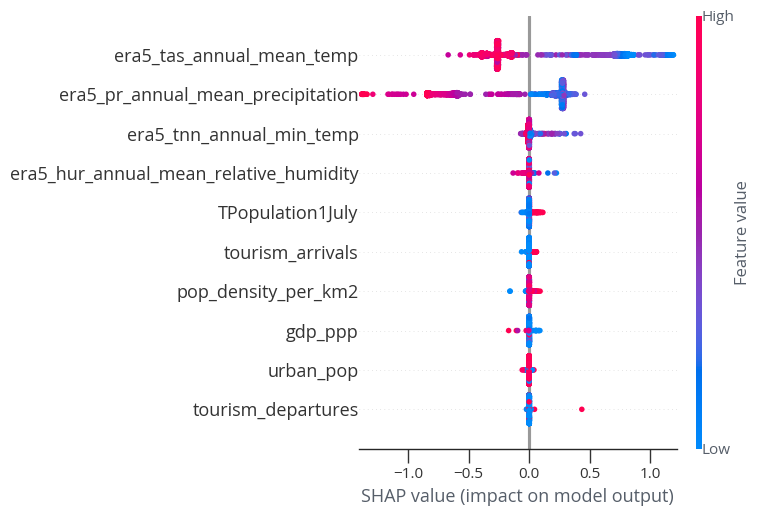


=== SHAP for Incidence Regression Model ===


PermutationExplainer explainer: 3111it [09:19,  5.45it/s]                          


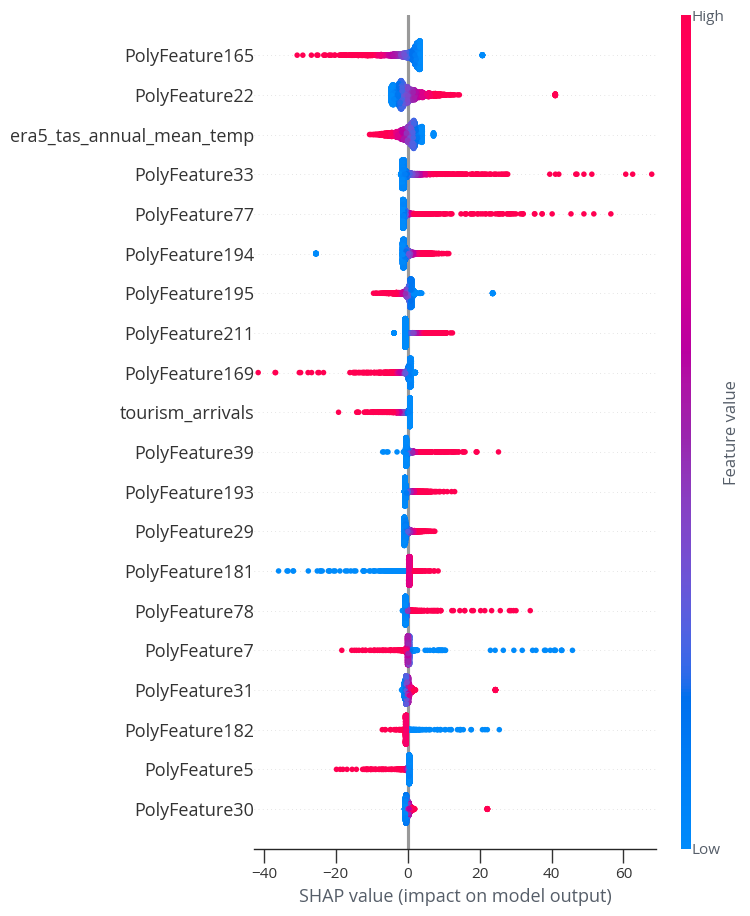

In [24]:
models = [class_model, incidence_model]
model_names = ['Endemicity Classification Model', 'Incidence Regression Model']
X_data = [X_val_class_scaled, X_val_incidence_scaled]  
model_features = [class_features, incidence_features]

for i, m in enumerate(models): 
    print(f"\n=== SHAP for {model_names[i]} ===")

    if i == 0:  
        current_features = features
    else:  # Incidence model
        n_features = X_data[i].shape[1]
        n_base = len(features)
        current_features = features + [f"PolyFeature{j+1}" for j in range(n_features - n_base)]

    explainer = shap.Explainer(m.predict, X_data[i])
    shap_values = explainer(X_data[i], max_evals=1500)
    shap.summary_plot(shap_values, X_data[i], feature_names=current_features, show=True)
